In [2]:
import os
import gc
import sys
import time
import json
import glob
import random
from pathlib import Path
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import itertools
from tqdm import tqdm

In [3]:
sys.path.append('Mask_RCNN')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/Users/dikshant/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dikshant/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dikshant/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dikshant/opt/anaconda3/lib/python3.7/site-packages/ten

In [23]:
category_list = ["Fish","Flower","Gravel","Sugar"]

In [11]:
ROOT_DIR = "working"

NUM_CATS = 4
IMAGE_SIZE = 512

In [21]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [12]:
class CloudConfig(Config):
    NAME = "cloud"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 4500
    VALIDATION_STEPS = 500
    
config = CloudConfig()
config.display()

# helper class taken from a source on kaggle #


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

# Load the best weights and visual assessment on small sample

In [13]:
class InferenceConfig(CloudConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [14]:

model_path='mask_rcnn_cloud_0009.h5'
model.load_weights(model_path, by_name=True)

In [15]:
# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [16]:
sample_df = pd.read_csv("understanding_cloud_organization/sample_submission.csv")
sample_df.head()

Image_Label EncodedPixels
0    002f507.jpg_Fish           1 1
1  002f507.jpg_Flower           1 1
2  002f507.jpg_Gravel           1 1
3   002f507.jpg_Sugar           1 1
4    0035ae9.jpg_Fish           1 1

In [17]:
test_df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId"])
for idx,row in sample_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    test_df = test_df.append({"image_id": image_filename},ignore_index=True)
test_df = test_df.drop_duplicates()

In [18]:
test_df.head()

image_id EncodedPixels CategoryId
0   002f507.jpg           NaN        NaN
4   0035ae9.jpg           NaN        NaN
8   0038327.jpg           NaN        NaN
12  004f759.jpg           NaN        NaN
16  005ba08.jpg           NaN        NaN

understanding_cloud_organization/test_images/3dbc60a.jpg

*** No instances to display *** 



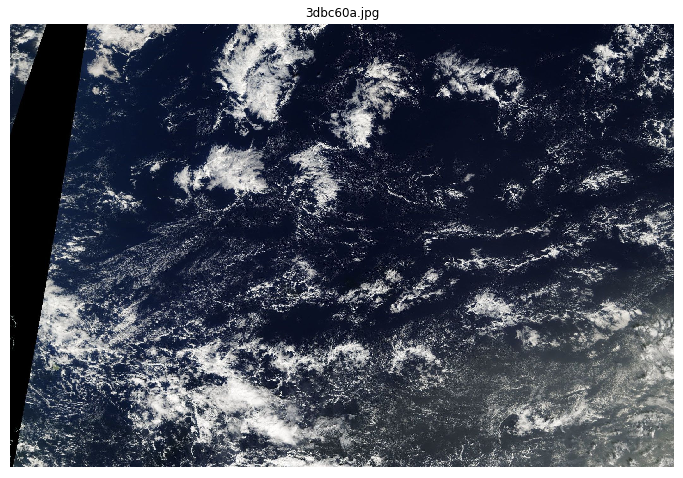

understanding_cloud_organization/test_images/80f9112.jpg


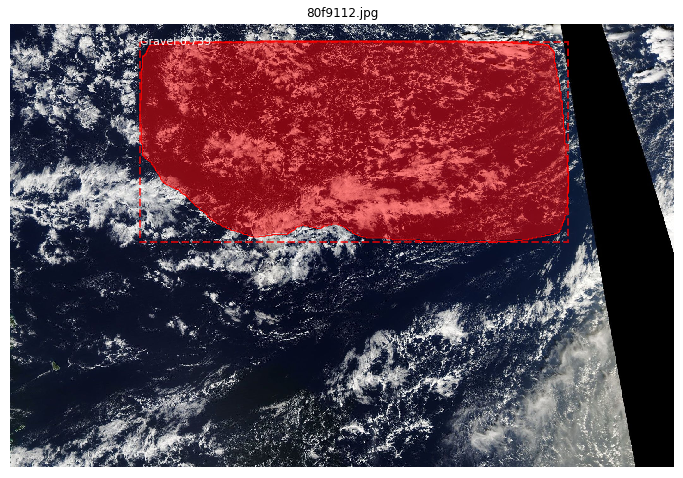

understanding_cloud_organization/test_images/f053dec.jpg

*** No instances to display *** 



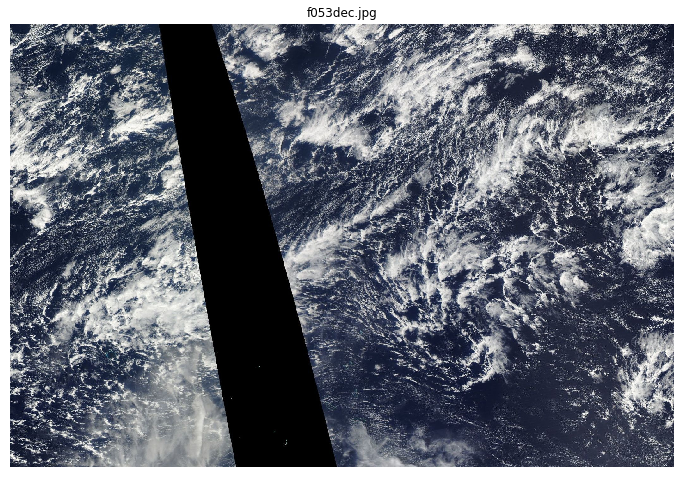

understanding_cloud_organization/test_images/2905b3e.jpg


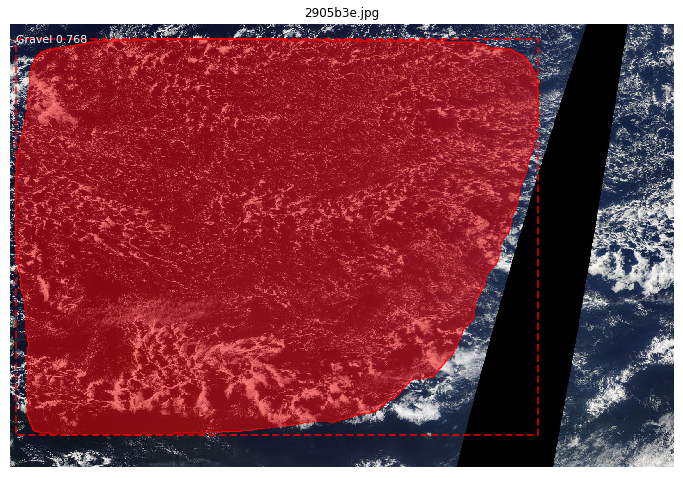

understanding_cloud_organization/test_images/d89c536.jpg


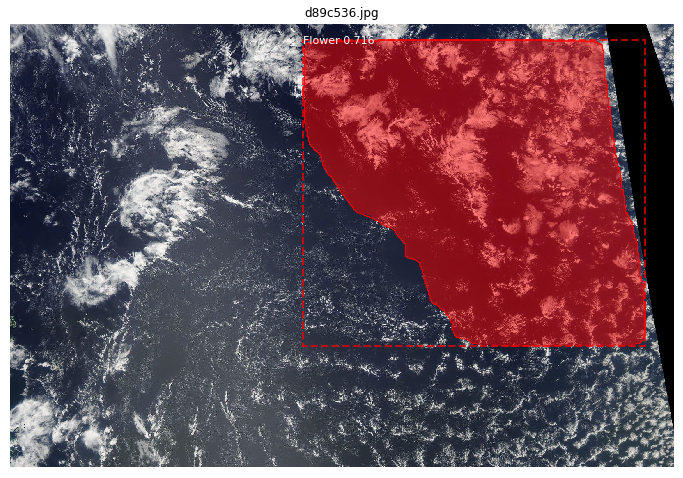

understanding_cloud_organization/test_images/a81420a.jpg


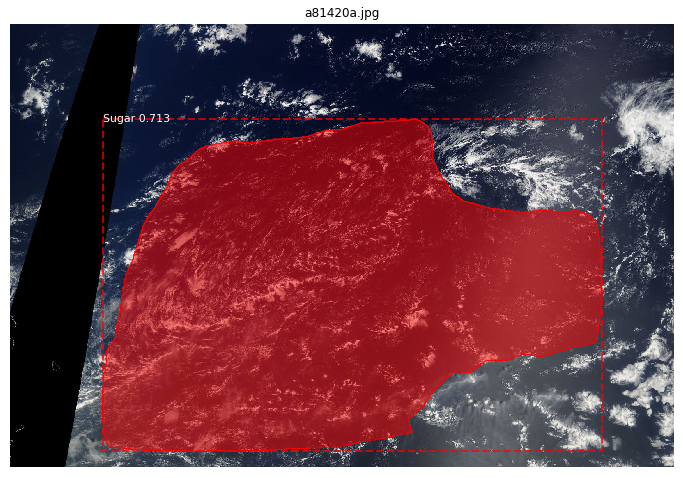

understanding_cloud_organization/test_images/ebe5621.jpg


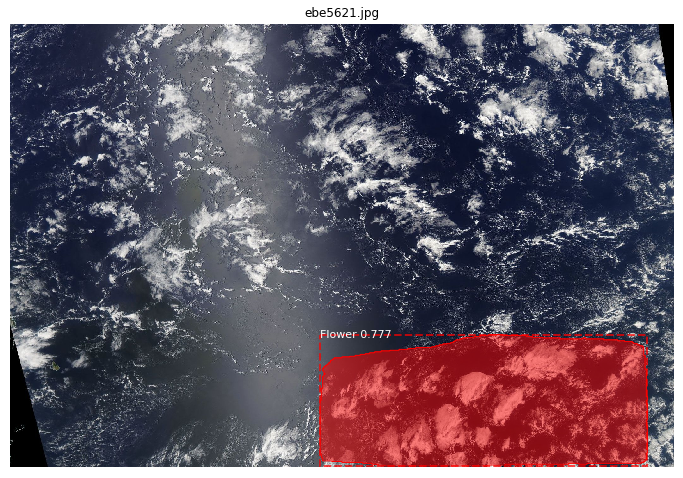

understanding_cloud_organization/test_images/6dcc343.jpg

*** No instances to display *** 



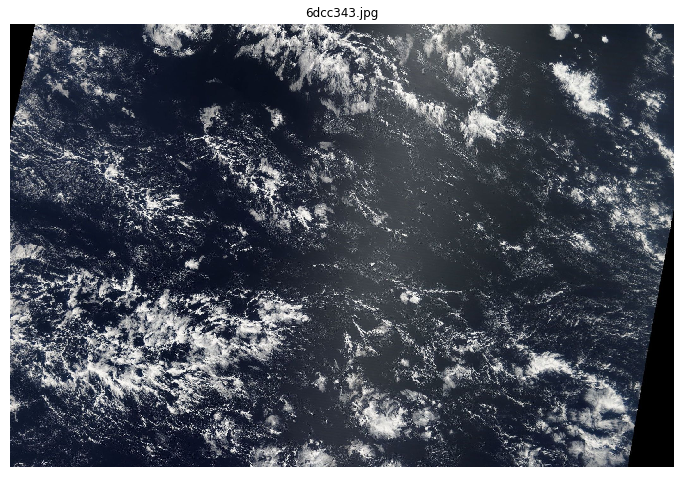

In [24]:
for i in range(8):
    image_id = test_df.sample()["image_id"].values[0]
    image_path = str('understanding_cloud_organization/test_images/'+image_id)
    print(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+category_list, r['scores'],
                                title=image_id, figsize=(12, 12))

# Submitting Predictions

In [19]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

In [ ]:
submission_df = sample_df.copy()
submission_df["EncodedPixels"] = ""
with tqdm(total=len(test_df)) as pbar:
    for i,row in test_df.iterrows():
        pbar.update(1)
        image_id = row["image_id"]
        image_path = str('../../input/understanding_cloud_organization/test_images/'+image_id)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = model.detect([resize_image(image_path)])
        r = result[0]

        if r['masks'].size > 0:
            masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
            for m in range(r['masks'].shape[-1]):
                masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                            (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            y_scale = img.shape[0]/IMAGE_SIZE
            x_scale = img.shape[1]/IMAGE_SIZE
            rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
            masks, rois, class_ids = r['masks'], r['rois'], r['class_ids']

            #The following piece of code is creating rectangular masks from
            # the ROIs instead of using the masks drawn by the MaskRCNN.
            # It also removes any missing area from the imagery from the predicted masks.
            # Everything is added directly to the submission dataframe.
            rectangular_masks = []
            mask_dict = {"Fish":[],"Flower":[],"Gravel":[],"Sugar":[]}
            for roi, class_id in zip(rois, class_ids):
                rectangular_mask = np.zeros((512,512))
                rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = 255
                img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_LINEAR)
                cropped_img = img[roi[0]:roi[2], roi[1]:roi[3]]
                
                kernel = np.ones((5,5),np.uint8)
                missing_data = np.where(cropped_img[:,:,0]==0,255,0).astype('uint8')
                contour_mask = np.zeros(missing_data.shape)
                opening = cv2.morphologyEx(missing_data.astype('uint8'), cv2.MORPH_OPEN, kernel)
                contours= cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                if len(contours[0])>0:
                    largest_contour = max(contours[0], key = cv2.contourArea)
                    cv2.fillPoly(contour_mask, pts =[largest_contour], color=(255))
                    kernel = np.ones((5,5),np.uint8)
                    opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel)
                    fixed_mask = np.where(opening[:,:]==255,0,255)
                    rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = fixed_mask.copy()
                    
                if mask_dict[category_list[class_id-1]]==[]:
                    mask_dict[category_list[class_id-1]] = rectangular_mask
                else:
                    previous_mask = mask_dict[category_list[class_id-1]].copy()
                    #prevents a bug where the mask is in int64
                    previous_mask = previous_mask.astype('float64')
                    boolean_mask = np.ma.mask_or(previous_mask, rectangular_mask)
                    merged_mask = np.where(boolean_mask, 255, 0)
                    mask_dict[category_list[class_id-1]] = merged_mask

            
            #Going through the masks per category and create a md mask in RLE
            for cloud_category in mask_dict.keys():
                if mask_dict[cloud_category]!=[]:
                    #resizing for submission
                    resized_mask = cv2.resize((mask_dict[cloud_category]/255).astype('uint8'), dsize=(525,350), interpolation = cv2.INTER_LINEAR)
                    rle_str = rle_encoding(resized_mask)
                    image_label = "{}_{}".format(image_id,cloud_category)
                    submission_df.loc[submission_df['Image_Label']==image_label,'EncodedPixels'] = rle_str
        else:
            masks, rois = r['masks'], r['rois']

In [ ]:
submission_df.query("EncodedPixels!=''").head()

In [ ]:
submission_df.to_csv("../../working/submission.csv",index=False)